In [1]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import graphlab as gl
import sklearn.metrics
%matplotlib inline

In [2]:
businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')
phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
reviews_train, reviews_test = train_test_split_reviews(phoenix_reviews)

In [3]:
train_sframe_full = gl.SFrame(reviews_train[['business_id', 'user_id', 'stars']])
test_sframe_full = gl.SFrame(reviews_test[['business_id', 'user_id', 'stars']])

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1481558927.log


This non-commercial license of GraphLab Create for academic use is assigned to andrew_ross@g.harvard.edu and will expire on November 23, 2017.


In [72]:
fac_model = gl.factorization_recommender.create(
    train_sframe_full, item_id='business_id', target='stars', verbose=False,
    num_factors=5, regularization=0.0001, linear_regularization=0.00001)

print 'train RMSE:', fac_model.evaluate_rmse(train_sframe_full, target='stars')['rmse_overall']
print ' test RMSE:', fac_model.evaluate_rmse(test_sframe_full, target='stars')['rmse_overall']

Recsys training: model = factorization_recommender

train RMSE: 1.07959146749
 test RMSE: 1.22520242033


In [31]:
import surprise

def dump_to_file(revs, fname):
    with open(fname, 'w') as f:
        for r in revs.itertuples():
            f.write('{}\t{}\t{}\n'.format(r.user_id, r.business_id, r.stars))   
dump_to_file(reviews_train, 'phoenix_reviews.data')
dump_to_file(reviews_test, 'phoenix_reviews.test')

reader = surprise.Reader(line_format='user item rating', sep='\t')
data = surprise.Dataset.load_from_folds([('phoenix_reviews.data', 'phoenix_reviews.test')], reader=reader)

svd_pp = surprise.prediction_algorithms.matrix_factorization.SVDpp()
surprise.evaluate(svd_pp, data)

Evaluating RMSE, MAE of algorithm SVDpp.

------------
Fold 1
RMSE: 1.2344
MAE:  0.9943
------------
------------
Mean RMSE: 1.2344
Mean MAE : 0.9943
------------
------------


CaseInsensitiveDefaultDict(list,
                           {u'mae': [0.99434851054475049],
                            u'rmse': [1.2344357910538006]})

In [34]:
import matrix_factorization_recommender as mfr

def X_and_y_of(df):
    return df[['user_id', 'business_id']].values, df['stars'].values
X_train, y_train = X_and_y_of(reviews_train)
X_test, y_test = X_and_y_of(reviews_test)

mf = mfr.MatrixFactorizationRecommender()
mf.fit(X_train, y_train)
print(mf.rmse(X_test, y_test))

1.23617982193


In [40]:
from baseline_calculator import *
drbc = DecoupledRegularizedBaselineCalculator()
drbc.fit(reviews_train, busi_reg_strength=2.75, user_reg_strength=5.25)
drbc.transform(reviews_train, key='baseline_stars')
drbc.transform(reviews_test, key='baseline_stars'); None

In [74]:
train_sframe_base = gl.SFrame(reviews_train[['business_id', 'user_id', 'baseline_stars']])
test_sframe_base = gl.SFrame(reviews_test[['business_id', 'user_id', 'baseline_stars']])

fac_model2 = gl.factorization_recommender.create(
    train_sframe_base, item_id='business_id', target='baseline_stars', verbose=False,
    num_factors=10, regularization=0.002, linear_regularization=0.0001)

predictions = fac_model2.predict(test_sframe_base)
np.sqrt(sklearn.metrics.mean_squared_error(reviews_test.stars, drbc.inverse_transform(reviews_test, predictions)))

Recsys training: model = factorization_recommender

1.2242945186960277

In [154]:
def rmses_after_limiting_to_at_least_n_reviews(n):
    multi_review_uids = users[users['review_count'] > n].user_id.unique()
    multi_review_train = reviews_train[reviews_train['user_id'].isin(multi_review_uids)]
    multi_review_test = reviews_test[reviews_test['user_id'].isin(multi_review_uids)]
    train_sframe_multi = gl.SFrame(multi_review_train[['business_id', 'user_id', 'stars']])
    test_sframe_multi = gl.SFrame(multi_review_test[['business_id', 'user_id', 'stars']])
    fac_model3 = gl.factorization_recommender.create(
        train_sframe_multi, item_id='business_id', target='stars', verbose=False,
        num_factors=5, regularization=0.00015, linear_regularization=0.000075)
    return fac_model3.evaluate_rmse(test_sframe_multi, target='stars')['rmse_overall']

In [155]:
limits = list(range(51))
rmses = [rmses_after_limiting_to_at_least_n_reviews(n) for n in limits]

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

In [110]:
drbc = DecoupledRegularizedBaselineCalculator()
baseline_rmses = []
for n in limits:
    multi_review_uids = users[users['review_count'] > n].user_id.unique()
    multi_review_train = reviews_train[reviews_train['user_id'].isin(multi_review_uids)]
    multi_review_test = reviews_test[reviews_test['user_id'].isin(multi_review_uids)]
    drbc.fit(multi_review_train, busi_reg_strength=2.75, user_reg_strength=5.25)
    baseline_rmses.append(drbc.baseline_rmse(multi_review_test))

In [106]:
train_pcts = []
test_pcts = []
for n in limits:
    multi_review_uids = users[users['review_count'] > n].user_id.unique()
    multi_review_train = reviews_train[reviews_train['user_id'].isin(multi_review_uids)]
    multi_review_test = reviews_test[reviews_test['user_id'].isin(multi_review_uids)]
    train_pcts.append(len(multi_review_train)/float(len(reviews_train)))
    test_pcts.append(len(multi_review_test)/float(len(reviews_test)))

In [113]:
mf_plus_baseline_rmses = []
for n in limits:
    multi_review_uids = users[users['review_count'] > n].user_id.unique()
    multi_review_train = reviews_train[reviews_train['user_id'].isin(multi_review_uids)]
    multi_review_test = reviews_test[reviews_test['user_id'].isin(multi_review_uids)]
    drbc.fit(multi_review_train, busi_reg_strength=2.75, user_reg_strength=5.25)
    drbc.transform(multi_review_train, key='baseline_stars')
    drbc.transform(multi_review_test, key='baseline_stars')
    train_sframe_bl = gl.SFrame(multi_review_train[['business_id', 'user_id', 'baseline_stars']])
    test_sframe_bl = gl.SFrame(multi_review_test[['business_id', 'user_id', 'baseline_stars']])
    fac_model4 = gl.factorization_recommender.create(
        train_sframe_bl, item_id='business_id', target='baseline_stars', verbose=False,
        num_factors=10, regularization=0.002, linear_regularization=0.0001)
    predictions = fac_model4.predict(test_sframe_bl)
    mf_plus_baseline_rmses.append(
        np.sqrt(sklearn.metrics.mean_squared_error(
                multi_review_test.stars,
                drbc.inverse_transform(multi_review_test, predictions))))

Recsys training: model = factorization_recommender

../util/baseline_calculator.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  reviews[key] = [r.stars - self.baseline_stars(r) for r in reviews.itertuples()]


Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = factorization_recommender

In [121]:
import seaborn
from baseline_calculator import *

In [131]:
n = 50
multi_review_uids = users[users['review_count'] > n].user_id.unique()
multi_review_train = reviews_train[reviews_train['user_id'].isin(multi_review_uids)]
multi_review_test = reviews_test[reviews_test['user_id'].isin(multi_review_uids)]
train_sframe_multi = gl.SFrame(multi_review_train[['business_id', 'user_id', 'stars']])
test_sframe_multi = gl.SFrame(multi_review_test[['business_id', 'user_id', 'stars']])

In [153]:
fac_model5 = gl.factorization_recommender.create(
        train_sframe_multi, item_id='business_id', target='stars', verbose=False,
        num_factors=5, regularization=0.00015, linear_regularization=0.000075)
fac_model5.evaluate_rmse(test_sframe_multi, target='stars')['rmse_overall']

Recsys training: model = factorization_recommender

1.021963303651639

In [158]:
len(reviews_train)

453454

In [159]:
len(reviews_train)/float(len(phoenix_reviews))

0.6999993825178452

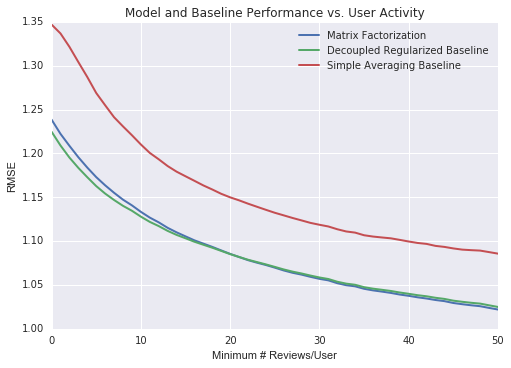

In [156]:
plt.plot(limits, rmses, label='Matrix Factorization', lw=2)
plt.plot(limits, baseline_rmses[:len(limits)], label='Decoupled Regularized Baseline', lw=2)
plt.plot(limits, baseline_rmses[len(limits):], label='Simple Averaging Baseline', lw=2)
#plt.plot(limits, mf_plus_baseline_rmses, label='both')
plt.xlabel('Minimum # Reviews/User')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.title('Model and Baseline Performance vs. User Activity')

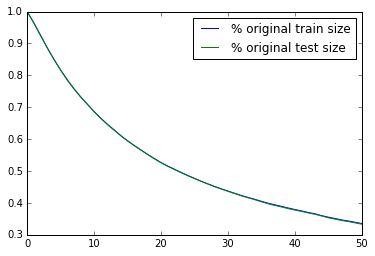

In [108]:
plt.plot(limits, train_pcts, label='% original train size')
plt.plot(limits, test_pcts, label='% original test size')
plt.legend()
plt.show()